In [2]:
import numpy as np
import pandas as pd 
import os
import sys
from matplotlib import pyplot as plt
sys.path.insert(1, '../')
from lib.prediction import show_trajectories
from lib.metrics import get_scores

# Задача

**Требуется:** по данным с акселерометра и гироскопа смартфона вычислить траекторию человека.  
  
**Вход:** 6 временных рядов - показания акселерометра и гироскопа по x, y, z.  
**Выход:** 2 временных ряда - координаты x и y человека в плоскости движения.  
**Метрика:** RMSE, MIE - среднее интегральное расстояние между траекториями.

# Данные

Ссылка на скачивание данных: [link](https://drive.google.com/file/d/1NQutO24hlRGUcpClqn-KXtPIRuY4a363/view?usp=sharing).

Данные представляют из себя набор экспериментов в которые входят показания датчиков и траектории.

Доступные данные разделены на обучение и контроль:  
- `train` содержит папки с экспериментами, в каждой из которых 3 таблицы: `acc.csv`, `gyro.csv`, `trajectory.csv` - данные с акселерометра и  гироскопа в течение эксперимента и траектория объекта, соответственно;  
- `test` содержит папки с экспериментами, в каждой из которых 2 таблицы: `acc.csv`, `gyro.csv`- данные с акселерометра и гироскопа в течение эксперимента;  

`acc.csv` содержит показания акселерометра по каждой из осей x, y, z и метки времени, в которые были сняты показания. Акселерометр показывает воздействующее на телефон мгновенное ускорение в данный момент времени (в том числе гравитацию).

`gyro.csv` содержит показания гироскопа по каждой из осей x, y, z и метки времени, в которые были сняты показания.
Гироскоп показывает мгновенную угловую скорость вращения телефона вокруг каждой из осей x, y, z в данный момент времени. 

`trajectory.csv` содержит координаты человека в плоскости движения по осям x, y и метки времени.

Внимание:
Показания гироскопа и аксeлерометра даны в мировой системе координат, т.е в системе, которая не зависит от ориентации или положения телефона.


# Результаты

Для демонстрации решения требуется:

- создать jupyter notebook, в котором будет полностью описано решение, проделанные шаги и проверенные гипотезы.

- создать папку predictions, в которой будут csv файлы со значениями траекторий для экспериментов из папки test. Файлы должны называться как номер эксперимента, для которого предсказывается траектория (`70.csv`, `71.csv` и т.п.). В csv файле должны содержаться колонки x, y, tmsp отвечающие за координаты объекта и отсчёты времени (формат как в файлах trajectory)

# Рекомендуемый pipeline решения:

Предполагается следующий pipeline решения поставленной задачи:  
- `fork` данного репозитория;  
- добавить `ttgadaev` в collaborators;  
- ознакомиться с критериями;  
- скачать данные;  
- ознакомиться с `notebooks/GettingStarted.ipynb`;  
- ознакомиться с данными;  
- ознакомиться сo [статьей](https://arxiv.org/pdf/1905.12853.pdf);  
- провести анализ данных;  
- сформировать и описать предполагаемые подходы к решению;
- провести необходимые исследования и проверить решения;
- реализовать нейросеть/нейросети (необязательно с нуля);  
- провалидировать модели;  
- выбрать **лучшую** модель и посчитать для нее метрики и создать необходимые файлы (см. `notebooks/GettingStarted.ipynb`);  
- отправить результаты на проверку.  


# Критерии 
При оценке решения этой задачи акцент будет делаться на (в порядке приоритета):


1. Качество исследования в jupyter notebook и чистота кода. В этот критерий входит читаемость и адекватность кода, содержательность комментариев, правильное оформление графиков (если таковые будут), отсутствие смысловых ошибок в коде. Наличие docstrings к написаным функциям приветствуется. Также будет оцениваться демонстрация предпринятых шагов и структурирование кода (разные по смыслу куски кода разделены по пакетам).

2. Оригинальность, эффективность и количество идей. Использование неочевидных шагов в решении, которые улучшают качество, будет хорошим плюсом. Наличие нескольких подходов и исследований также будет ценится выше, чем один подход.

3. Значение метрик на контрольной выборке. 

4. Пред- и постобработка данных. 

# Данные, метрики и доступные функции

Загрузим данные и посмотрим на их формат

In [2]:
path = './data/train/'
experiments = os.listdir(path)
print(experiments[:5])
exp = path + experiments[42] + '/'
print(exp)
tables = sorted(os.listdir(path + experiments[0]))
print(tables)

['65', '57', '13', '25', '40']
./data/train/27/
['acc.csv', 'gyro.csv', 'trajectory.csv']


In [3]:
acc = pd.read_csv(exp + tables[0], index_col=0)
gyro = pd.read_csv(exp + tables[1], index_col=0)
trajectory = pd.read_csv(exp + tables[2], index_col=0)

In [4]:
acc.head()

,x,y,z,tmsp
0,-0.017208,0.073279,9.897381,0.000000
1,0.006613,0.102490,9.890372,0.004944
2,0.027197,0.116541,9.894765,0.009857
3,0.021905,0.102199,9.895846,0.014801
4,0.016564,0.112642,9.883012,0.019745


In [5]:
trajectory.head()

,x,y,tmsp
0,0.004538,-0.007167,0.000000
1,0.004542,-0.007181,0.004944
2,0.004545,-0.007193,0.009857
3,0.004549,-0.007205,0.014801
4,0.004552,-0.007214,0.019745


Нарисуем траекторию

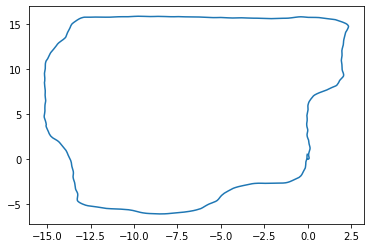

In [6]:
_=plt.plot(trajectory.x.values, trajectory.y.values)

Для оценки моделей предсказания траекторий предоставляются две функции: `get_scores` и `show_strajectories`.
Обе функции на вход принимают два аргумента: реальную траекторию и предсказанную траеткорию в формате `pd.DataFrame` как в таблице `trajectory` (см. выше). 

Функция `get_scores` выдает словарь значений метрик предсказания. 

Функция `show_trajectories` отрисовывает траектории и график расстояния между предсказанными положениями в каждый момент времени, а также возвращает значение метрик. На графике расстояния если синияя линяя лежит ниже зелёной пунктирной, значит ошибка не более 10%, это хороший результат.

In [7]:
get_scores(trajectory, trajectory)

{'rmse': 0.0, 'mie': 0.0}

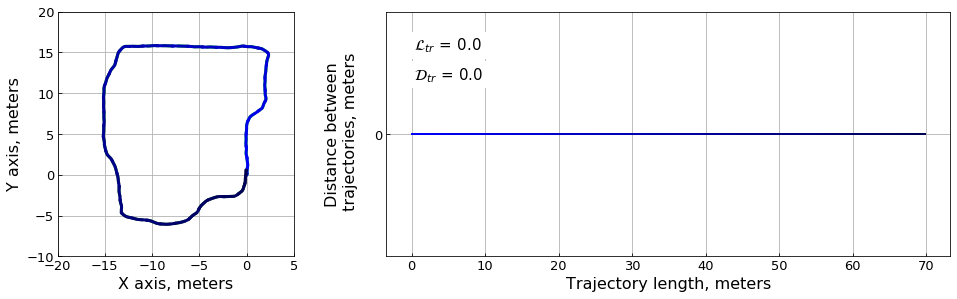

{'rmse': 0.0, 'mie': 0.0}


In [8]:
figure, scores = show_trajectories(trajectory, trajectory)
print(scores)

Продемонстрируем работу функции на предсказании модели случайного блуждания

In [9]:
from scipy.stats import norm

In [10]:
n = trajectory.shape[0]
dt = np.diff(trajectory.tmsp.values).mean()

In [11]:
r_x = norm.rvs(size=(n,), scale=np.sqrt(dt))
r_y = norm.rvs(size=(n,), scale=np.sqrt(dt))
brownian_x = np.cumsum(r_x, axis=-1)
brownian_y = np.cumsum(r_y, axis=-1)

In [12]:
trajectory_pred = pd.DataFrame()
trajectory_pred['x'] = brownian_x
trajectory_pred['y'] = brownian_y
trajectory_pred['tmsp'] = trajectory.tmsp
trajectory_pred.head()

,x,y,tmsp
0,0.092168,0.078226,0.000000
1,0.060673,-0.034074,0.004944
2,0.076956,0.072042,0.009857
3,0.152565,0.006268,0.014801
4,0.282583,0.061790,0.019745


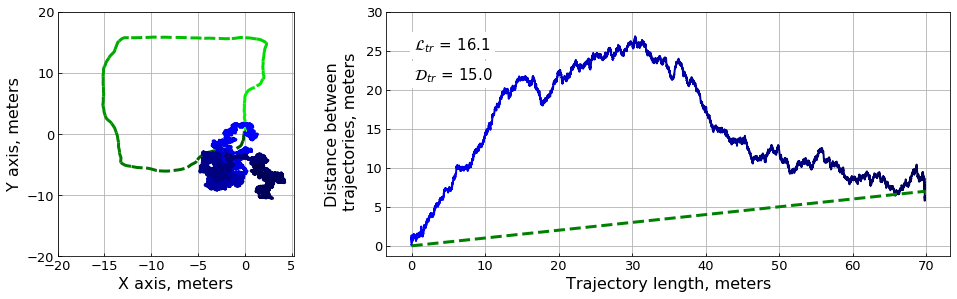

{'rmse': 16.072476734818977, 'mie': 15.047628915650455}


In [13]:
figure, scores = show_trajectories(trajectory, trajectory_pred)
print(scores)

# Идеи и подсказки
Подсказки:

- Если численно  проинтегрировать показания гироскопа, можно получить ориентацию телефона в каждый момент времени
- Если будет желание пользоваться ориентацией телефона, можно использовать библиотеку numpy-quaternions
- Чтобы понять как направлен вектор гравитации, можно взять ускорение в начальный момент времени (когда человек ещё не в движении) и поворачивать его с помощью данных с гироскопа

Какие методы можно попробовать:

- Детектировать моменты шагов и для каждого шага предсказывать смещение объекта какой-то моделью (например, LSTM)

- Связать некоторый вектор с телефоном, по ориентации телефона вычислять проекции вектора на плоскость движения и проинтегрировав проекции получить траекторию

- Нарезать данные с датчиков и траектории на окошки (например по 1 секунде) и обучить какую-нибудь модель машинного обучения на регрессию двух проекций скоростей (производных траеткорий) по этим окошкам. Хорошо работает нейросеть (например, ResNet-18). См. статью 
[RoNIN](https://arxiv.org/pdf/1905.12853.pdf).

Удачи!
